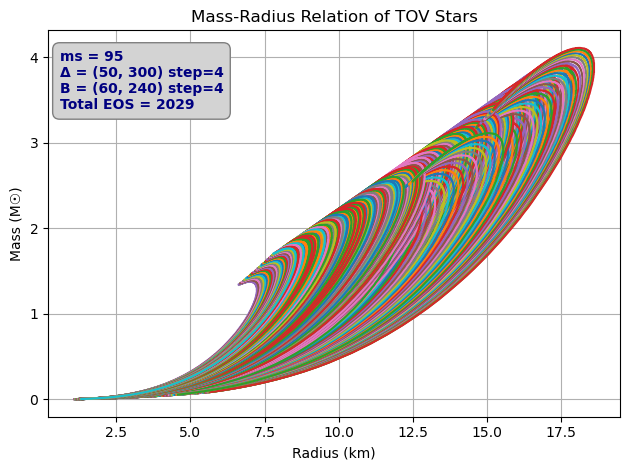

In [5]:
import os
import matplotlib.pyplot as plt
import numpy as np
import fnmatch

# List of folders to search
folders = ['TOV_results_Quark_Stars_part1', 'TOV_results_Quark_Stars_part2']
pattern = '*.csv'

# Loop through each folder and collect matching CSV files
for folder in folders:
    if not os.path.exists(folder):
        continue  # Skip missing folders

    files = [f for f in os.listdir(folder) if fnmatch.fnmatch(f, pattern)]

    for file in files:
        filepath = os.path.join(folder, file)
        
        # Load CSV data, skipping header
        data = np.genfromtxt(filepath, delimiter=',', skip_header=1)

        if data.ndim == 1 or data.shape[1] < 2:
            continue  # Skip malformed or incomplete files

        # Plot Mass vs Radius
        plt.plot(data[:, 1], data[:, 0], label=f"{folder}/{file.split('.')[0]}")

# Final plot formatting
plt.ylabel("Mass (M☉)")
plt.xlabel("Radius (km)")
plt.title("Mass-Radius Relation of TOV Stars")
plt.grid(True)
plt.text(
    0.02, 0.95,
    'ms = 95\nΔ = (50, 300) step=4\nB = (60, 240) step=4\nTotal EOS = 2029',
    transform=plt.gca().transAxes,
    fontsize=10,
    fontweight='bold',
    color='navy',
    ha='left',  # horizontal alignment
    va='top',   # vertical alignment
    bbox=dict(facecolor='lightgray', edgecolor='gray', boxstyle='round,pad=0.5')
)

plt.tight_layout()
plt.show()


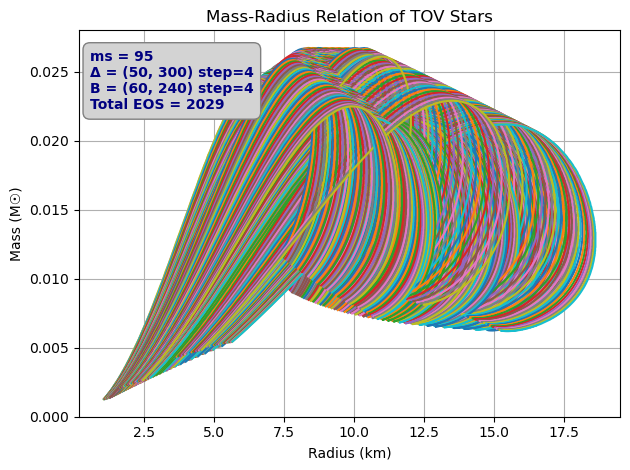

In [6]:
import os
import matplotlib.pyplot as plt
import numpy as np
import fnmatch

# List of folders to search
folders = ['TOV_results_Qark_Stars_tidal']
pattern = '*.csv'

# Loop through each folder and collect matching CSV files
for folder in folders:
    if not os.path.exists(folder):
        continue  # Skip missing folders

    files = [f for f in os.listdir(folder) if fnmatch.fnmatch(f, pattern)]

    for file in files:
        filepath = os.path.join(folder, file)
        
        # Load CSV data, skipping header
        data = np.genfromtxt(filepath, delimiter=',', skip_header=1)

        if data.ndim == 1 or data.shape[1] < 2:
            continue  # Skip malformed or incomplete files

        # Plot Mass vs Radius
        plt.plot(data[:, 1], data[:, 3], label=f"{folder}/{file.split('.')[0]}")

# Final plot formatting
plt.ylabel("Mass (M☉)")
plt.xlabel("Radius (km)")
plt.title("Mass-Radius Relation of TOV Stars")
plt.grid(True)
plt.text(
    0.02, 0.95,
    'ms = 95\nΔ = (50, 300) step=4\nB = (60, 240) step=4\nTotal EOS = 2029',
    transform=plt.gca().transAxes,
    fontsize=10,
    fontweight='bold',
    color='navy',
    ha='left',  # horizontal alignment
    va='top',   # vertical alignment
    bbox=dict(facecolor='lightgray', edgecolor='gray', boxstyle='round,pad=0.5')
)

plt.tight_layout()
plt.show()


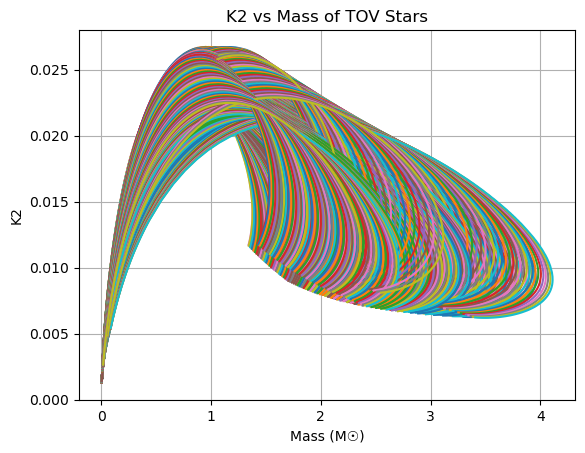

In [7]:
# Plot K2 vs Mass 
import os
import matplotlib.pyplot as plt
import numpy as np
import fnmatch
# List of folders to search
folders = ['TOV_results_Qark_Stars_tidal']
pattern = '*.csv'
# Loop through each folder and collect matching CSV files
for folder in folders:
    if not os.path.exists(folder):
        continue  # Skip missing folders

    files = [f for f in os.listdir(folder) if fnmatch.fnmatch(f, pattern)]

    for file in files:
        filepath = os.path.join(folder, file)
        
        # Load CSV data, skipping header
        data = np.genfromtxt(filepath, delimiter=',', skip_header=1)

        if data.ndim == 1 or data.shape[1] < 2:
            continue  # Skip malformed or incomplete files

        # Plot K2 vs Mass
        plt.plot(data[:, 0], data[:, 3], label=f"{folder}/{file.split('.')[0]}")
# Final plot formatting
plt.ylabel("K2")
plt.xlabel("Mass (M☉)")
plt.title("K2 vs Mass of TOV Stars")
plt.grid(True)


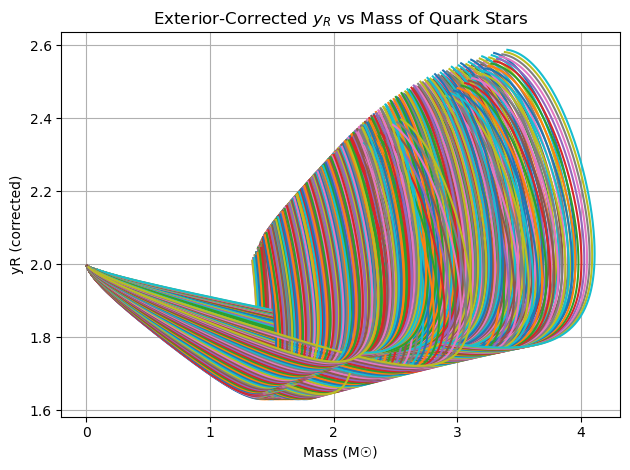

In [8]:
import os
import matplotlib.pyplot as plt
import numpy as np
import fnmatch

folders = ['TOV_results_Qark_Stars_tidal']
pattern = '*.csv'

for folder in folders:
    if not os.path.exists(folder):
        continue

    files = [f for f in os.listdir(folder) if fnmatch.fnmatch(f, pattern)]

    for file in files:
        filepath = os.path.join(folder, file)
        data = np.genfromtxt(filepath, delimiter=',', skip_header=1)

        if data.ndim == 1 or data.shape[1] < 4:
            continue

        M = data[:, 0]
        yR_ext = data[:, 4]

        valid = np.isfinite(M) & np.isfinite(yR_ext)

        if np.any(valid):
            plt.plot(M[valid], yR_ext[valid], label=file.split('.')[0])

plt.xlabel("Mass (M☉)")
plt.ylabel("yR (corrected)")
plt.title("Exterior-Corrected $y_R$ vs Mass of Quark Stars")
plt.grid(True)
# plt.legend(fontsize=6)
plt.tight_layout()
plt.show()

